In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Categorical
from sklearn.gaussian_process import kernels
data_dir = 'data'

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'), low_memory=False)
df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [7]:
def compute_kernel(X, Y, kernel: kernels.Kernel):
    """
    Compute the kernel matrix for the given data and kernel.

    Parameters:
    X : array-like, shape (n_samples_X, n_features)
        First set of samples.
    Y : array-like, shape (n_samples_Y, n_features)
        Second set of samples.
    kernel : kernels.Kernel
        The kernel function to use for computing the kernel matrix.

    Returns:
    K : array-like, shape (n_samples_X, n_samples_Y)
        The kernel matrix computed between X and Y.
    """
    return kernel(X, Y)

def compute_mmd(X, Y, kernel: kernels.Kernel):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two distributions using the specified kernel.
    """
    K_XX = compute_kernel(X, X, kernel)
    K_YY = compute_kernel(Y, Y, kernel)
    K_XY = compute_kernel(X, Y, kernel)

    mmd = np.mean(K_XX) + np.mean(K_YY) - 2 * np.mean(K_XY)
    return mmd


TODO: Use a Gaussian Process Regressor with L1/L2/(L1+L2) Regularization + Adam/AdamW/SGD+Momentum

In [12]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['ABETA_bl']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

kernel = (1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e1, 1e3))
          # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
          )

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=5e-1, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

In [14]:
print(f'MMD between training and test sets: {compute_mmd(X_train, X_test, kernel):.4f}')

MMD between training and test sets: 0.0076


In [239]:
gpr.fit(X_train, y_train)

,kernel,1**2 * RBF(length_scale=10)
,alpha,0.5
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RBF(length_scale=10)
,kernel__k1__constant_value,1.0


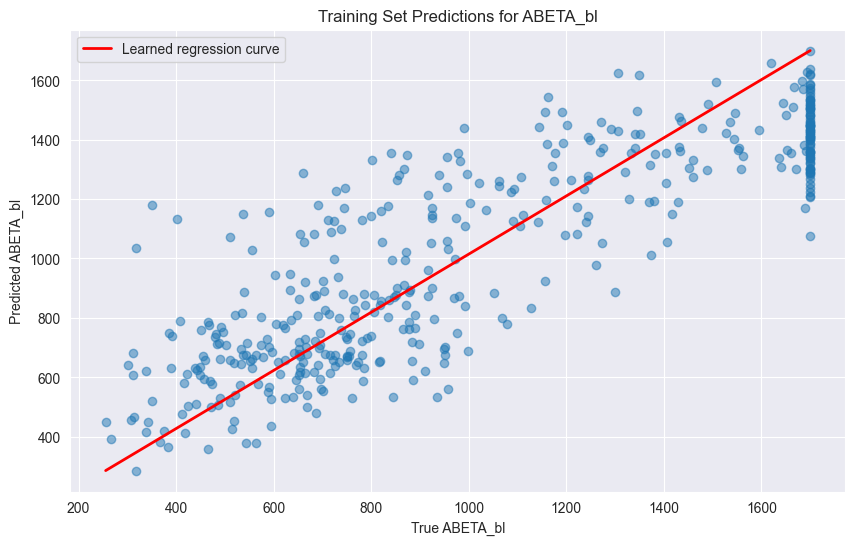

Training MSE: 57372.99
Training R^2: 0.72


In [240]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)
train_gradient = np.gradient(y_mean_train)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

In [ ]:
# Plot the distribution of the training set predictions and the true values
sns.histplot(y_train, color='blue', label='True ABETA_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted ABETA_bl', kde=True)
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted ABETA_bl on Training Set')
plt.legend()

Testing set performance

In [ ]:
y_mean_test, y_std_test = gpr.predict(X_train, return_std=True)
train_gradient = np.gradient(y_mean_test)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_test, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_test.min(), y_mean_test.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_test)
r2_train = r2_score(y_train, y_mean_test)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

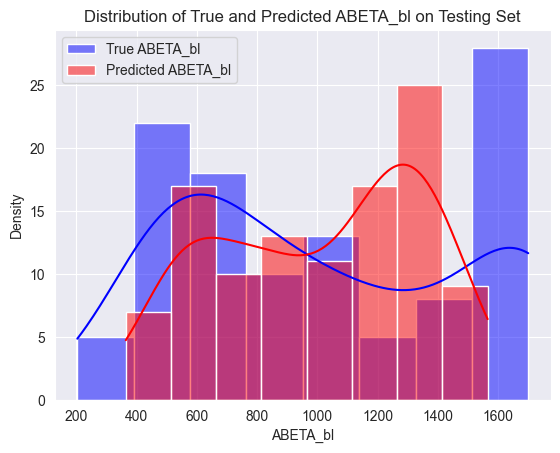

In [243]:
# Plot the distribution of the testing set predictions and the true values
sns.histplot(y_test, color='blue', label='True ABETA_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted ABETA_bl', kde=True)
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted ABETA_bl on Testing Set')
plt.legend()

TODO: Explore other kernels for potentially better performance

In [311]:
def make_kernel(name):
    if name == "RBF_1e-5":
        return RBF(length_scale=1e-5)
    elif name == "RBF_1e-4":
        return RBF(length_scale=1e-4)
    elif name == "RBF_1e-3":
        return RBF(length_scale=1e-3)
    elif name == "RBF_1e-2":
        return RBF(length_scale=1e-2)
    elif name == "RBF_1e-1":
        return RBF(length_scale=1e-1)
    elif name == "RBF_1e0":
        return RBF(length_scale=1e0)
    elif name == "RBF_1e1":
        return RBF(length_scale=1e1)
    elif name == "RBF_1e2":
        return RBF(length_scale=1e2)
    elif name == "Matern_1e-5":
        return Matern(length_scale=1e-5, nu=2.5)
    elif name == "Matern_1e-4":
        return Matern(length_scale=1e-4, nu=2.5)
    elif name == "Matern_1e-3":
        return Matern(length_scale=1e-3, nu=2.5)
    elif name == "Matern_1e-2":
        return Matern(length_scale=1e-2, nu=2.5)
    elif name == "Matern_1e-1":
        return Matern(length_scale=1e-1, nu=2.5)
    elif name == "Matern_1e0":
        return Matern(length_scale=1e0, nu=2.5)
    elif name == "Matern_1e1":
        return Matern(length_scale=1e1, nu=2.5)
    elif name == "Matern_1e2":
        return Matern(length_scale=1e2, nu=2.5)
    else:
        raise ValueError(f"Unknown kernel: {name}")

search_params = {
    'kernel': Categorical(["RBF_1e-5", "RBF_1e-4", "RBF_1e-3", "RBF_1e-2", "RBF_1e-1", "RBF_1e0", "RBF_1e1", "RBF_1e2", "Matern_1e-5", "Matern_1e-4", "Matern_1e-3", "Matern_1e-2", "Matern_1e-1", "Matern_1e0", "Matern_1e1", "Matern_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RBF(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Training set performance

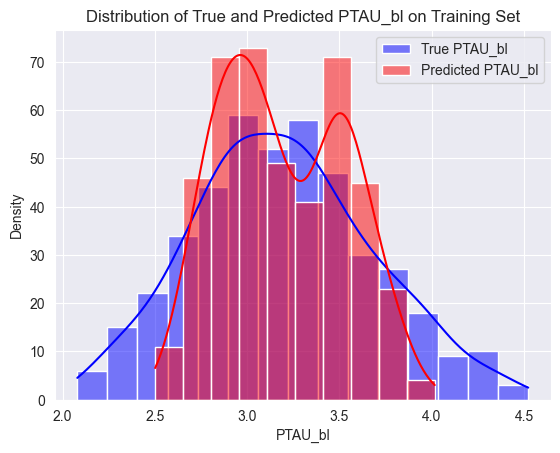

In [349]:
# Plot the distribution of the training set predictions and the true values
sns.histplot(y_train, color='blue', label='True PTAU_bl', kde=True)
sns.histplot(y_mean_train, color='red', label='Predicted PTAU_bl', kde=True)
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted PTAU_bl on Training Set')
plt.legend()
plt.show()

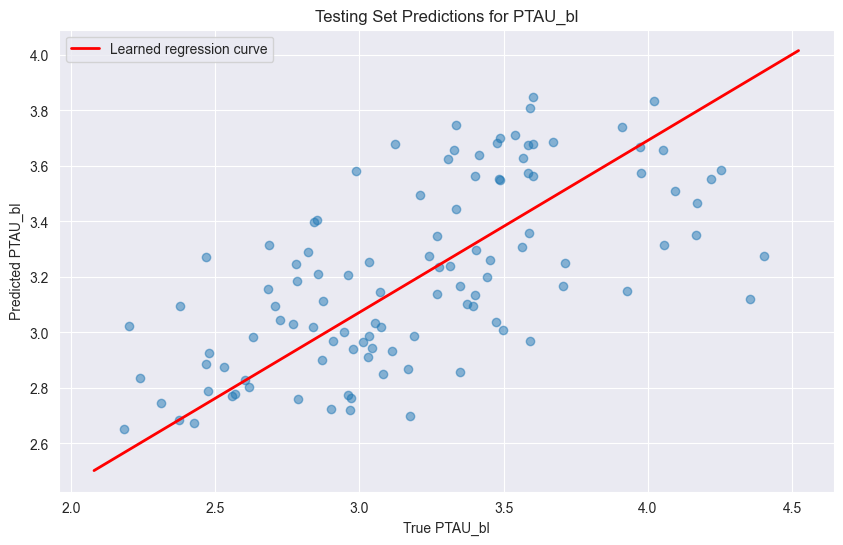

Testing MSE: 0.16
Testing R^2: 0.40


In [350]:
y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)
test_gradient = np.gradient(y_mean_test)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_mean_test, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True PTAU_bl')
plt.ylabel('Predicted PTAU_bl')
plt.title('Testing Set Predictions for PTAU_bl')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_mean_test)
r2_test = r2_score(y_test, y_mean_test)

print(f'Testing MSE: {mse_test:.2f}')
print(f'Testing R^2: {r2_test:.2f}')

# Predict TAU_bl #

In [306]:
kernel = (
    RBF(length_scale=1e-3)
    # 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1e5))
          # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
          )

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=0.5480223343121704, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

gpr.fit(X_train, y_train)

,kernel,RBF(length_scale=0.001)
,alpha,0.5480223343121704
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,0.001
,kernel__length_scale_bounds,"(1e-05, ...)"


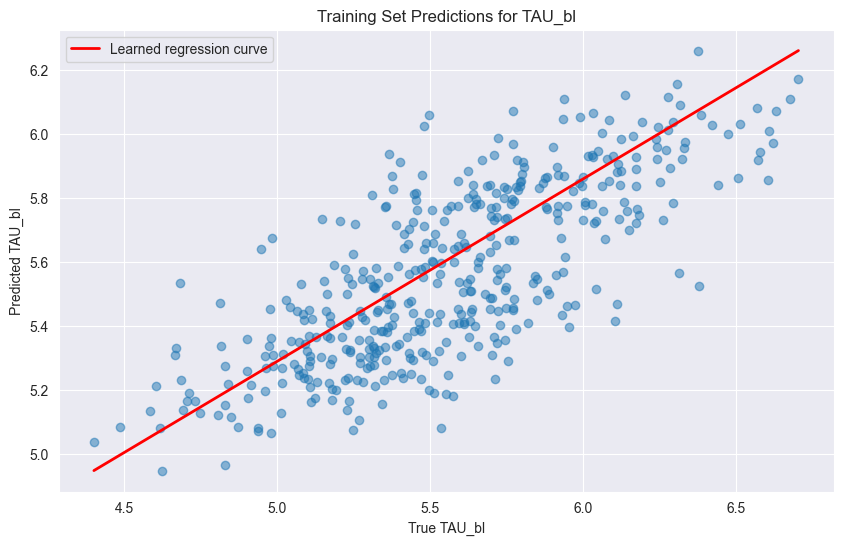

Training MSE: 0.08
Training R^2: 0.56


In [307]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)
train_gradient = np.gradient(y_mean_train)
# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# Plot the learnt regression curve
plt.plot(
    [y_train.min(), y_train.max()],
    [y_mean_train.min(), y_mean_train.max()],
    'r-',
    lw=2,
    label='Learned regression curve',
)
plt.xlabel('True TAU_bl')
plt.ylabel('Predicted TAU_bl')
plt.title('Training Set Predictions for TAU_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

Testing set performance

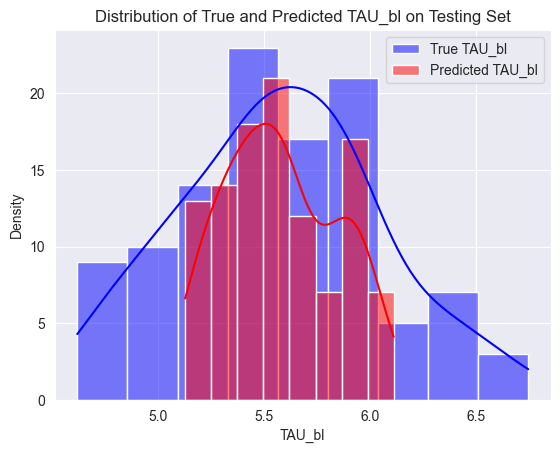

In [310]:
# Plot the distribution of the testing set predictions and the true values
sns.histplot(y_test, color='blue', label='True TAU_bl', kde=True)
sns.histplot(y_mean_test, color='red', label='Predicted TAU_bl', kde=True)
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.title('Distribution of True and Predicted TAU_bl on Testing Set')
plt.legend()